In [36]:
import os
import git
from pathlib import Path
import numpy as np
import pandas as pd
import seaborn
import matplotlib.pyplot as plt

ROOT_DIR =  Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
SAVE_FIGS = True

In [37]:
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
from reporting import *
plots_path = os.path.join(ROOT_DIR, "publication", "paper", "final_plots", "results")
main_df = main_df.copy()
np.random.seed(0)

# KS Stats Across Priors

In [38]:
statistical_cutoffs = -np.arange(1, 13, 2) # -np.hstack([np.arange(1, 13, 2), np.arange(14, 30, 2), np.arange(30, 100, 5)]) # -np.array([x**2 for x in range(1, 8)]) #np.arange(1, 40, 5)

for i in statistical_cutoffs:
    alpha = 10.0**i
    main_df[f'kstest_stat_cutoff_{i}'] = np.nan_to_num(stats.kstwo(n=main_df['total_samples']).isf(alpha))

alphas = np.linspace(0.1, 0.4, len(statistical_cutoffs))
alphas, [10.0**i for i in list(statistical_cutoffs)]

(array([0.1 , 0.16, 0.22, 0.28, 0.34, 0.4 ]),
 [0.1, 0.001, 1e-05, 1e-07, 1e-09, 1e-11])

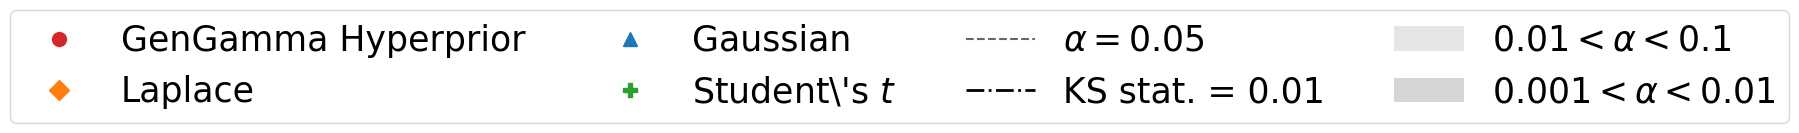

In [39]:
practical_pass = 0.01
marker_size = 10 
fontsize = 25
markersize = 10
labelsize = 15
markertypes = ['o', 'D', '^', 'P']
prior_colors = {'o' : 'tab:red', 'D' : 'tab:orange', '^' : 'tab:blue', 'P' : 'tab:green'}
labels = ['GenGamma Hyperprior', 'Laplace', 'Gaussian', r'Student\'s $t$', r'$\alpha=0.05$', 'KS stat. = 0.01', r'$0.01<\alpha<0.1$', r'$0.001<\alpha<0.01$']
points = [Line2D([0], [0], color=prior_colors[m], linestyle='', marker=m, markersize=10) for m in markertypes] + [
    Line2D([0], [0], color='black', linestyle='--', markersize=10, alpha=0.6),
    Line2D([0], [0], linestyle="-.", color='black', linewidth=2),
    Rectangle((0, 0), 1, 1, alpha=alphas[0], facecolor='black'),
    Rectangle((0, 0), 1, 1, alpha=alphas[1], facecolor='black'),
]

fig, ax = plt.subplots(figsize=(5, 1))
# fig.patch.set_facecolor('#F9FCD6')
ax.axis('off')  # Turn off the axes, including borders and tick marks

plt.legend(points, labels, ncols=len(labels)//2, loc='center', fontsize=fontsize, frameon=True)  # Add legend without frame

if SAVE_FIGS:
    save_path = os.path.join(plots_path, "ksstat_legend.jpg")
    plt.savefig(save_path, dpi=DPI, bbox_inches='tight')  # Remove whitespace

plt.show()


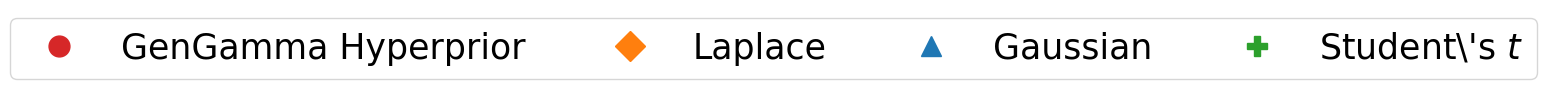

In [40]:
practical_pass = 0.01
marker_size = 10 
fontsize = 25
markersize = 10
labelsize = 15
markertypes = ['o', 'D', '^', 'P']
labels = ['GenGamma Hyperprior', 'Laplace', 'Gaussian', r'Student\'s $t$']
points = [Line2D([0], [0], color=prior_colors[m], linestyle='', marker=m, markersize=10) for m in markertypes]

fig, ax = plt.subplots(figsize=(5, 1))
# fig.patch.set_facecolor('#F9FCD6')
ax.axis('off')  # Turn off the axes, including borders and tick marks

plt.legend(points, labels, ncols=len(labels), loc='center', fontsize=fontsize, frameon=True, markerscale=1.5)  # Add legend without frame

if SAVE_FIGS:
    save_path = os.path.join(plots_path, "ksstat_legend_priors.jpg")
    plt.savefig(save_path, dpi=DPI, bbox_inches='tight')  # Remove whitespace

plt.show()


In [41]:
name_mapping = {
                'syntheticMRI3Dfull': 'syntheticMRI3D',
                'syntheticMRI2Daxial': 'syntheticMRI2D (axial)',
                'syntheticMRI2Dsagittal': 'syntheticMRI2D (sagittal)',
                'syntheticMRI2Dcoronal': 'syntheticMRI2D (coronal)',
                'spaceNetfull': 'spaceNet',
                'cocoindoor': 'coco (indoor)',
                'cocooutdoor': 'coco (outdoor)',
                'pastisfull': 'pastis',
                'segmentAnythingfull': 'segmentAnything',
                'agriVisionfull': 'agriVision',
                'standardTestingfull': 'classical'}

main_df['dataset'] = (main_df['dataset'] + main_df['subset']).replace(name_mapping)

In [42]:
def plot_single_ks(
    main_df,
    dataset_name,
    transform,
    orientation=None,
    statistical_cutoffs=None,
    alphas=None,
    toggle_markeredgecolor=True,
    log_scale=True,
    practical_pass=0.01,
    marker_size=10,
    fontsize=25,
    SAVE_FIGS=False,
    plots_path=None,
    DPI=300,
    custom_title=None,     
    show_ylabel=False,
    show_yticklabels=True
):
    """
    Plot a single KS-statistic panel for one dataset/transform/orientation.
    Designed for DataFrames where cutoff columns are named like:
        'kstest_stat_cutoff_-1', 'kstest_stat_cutoff_-3', etc.
    """

    fig, ax = plt.subplots(figsize=(8, 6))

    # --- Filter the DataFrame ---
    df = main_df[(main_df['dataset'] == dataset_name) & (main_df['transform'] == transform)].copy()
    if orientation is not None and 'orientation' in df.columns:
        df = df[df['orientation'] == orientation]
    if df.empty:
        raise ValueError(f"No data found for dataset={dataset_name}, transform={transform}, orientation={orientation}")

    df = df.sort_values('kstest_stat_cutoff_-1')

    # --- Log scale ---
    if log_scale:
        ax.set_yscale('log')

    # --- Determine y-limits ---
    y_min = np.min(np.array(df.filter(regex='kstest_stat_\\w+$')))
    y_max = np.max(np.array(df.filter(regex='kstest_stat_\\w+$')))
    y_limits = (10 ** np.floor(np.log10(y_min)), 10 ** np.ceil(np.log10(y_max)))
    y_limits = (5 * 10.**-4, 5 * 10.**-1)
    ax.set_ylim(y_limits)

    # --- Compute cutoff shading regions ---
    cutoff = df.groupby('group').agg({
        f'kstest_stat_cutoff_{i}': 'first' for i in statistical_cutoffs
    }).reset_index()

    for k in range(len(statistical_cutoffs) - 1):
        ax.fill_between(
            cutoff['group'],
            cutoff[f'kstest_stat_cutoff_{statistical_cutoffs[k]}'],
            cutoff[f'kstest_stat_cutoff_{statistical_cutoffs[k + 1]}'],
            color='black', alpha=alphas[k], ec=None
        )

    ax.fill_between(
        cutoff['group'],
        cutoff[f'kstest_stat_cutoff_{statistical_cutoffs[-1]}'],
        y_limits[1],
        color='black', alpha=alphas[-1], ec=None
    )

    # --- Reference lines ---
    ref_cutoff = f'kstest_stat_cutoff_{statistical_cutoffs[0]}'
    if ref_cutoff in df.columns:
        ref_line = df.groupby('group').agg({ref_cutoff: 'first'}).reset_index()
        sns.lineplot(
            x=ref_line['group'], y=ref_line[ref_cutoff],
            linestyle="--", color='black', linewidth=2, alpha=0.6, ax=ax
        )

    ax.axhline(y=practical_pass, linestyle="-.", color='black', linewidth=2)

    # --- Plot KS statistics ---
    stat_pairs = {
        'kstest_stat_gaussian': '^',
        'kstest_stat_laplace': 'D',
        'kstest_stat_t': 'P',
        'kstest_stat_best': 'o'
    }
    for stat_name, marker in stat_pairs.items():
        if stat_name in df.columns:
            sns.lineplot(
                data=df, x='group', y=stat_name,
                marker=marker, ax=ax, alpha=0.8, markersize=marker_size,
                markeredgecolor=None if not toggle_markeredgecolor else 'white'
            )

    if not show_yticklabels:
        ax.set_yticklabels([])
        
    # --- Labels and title ---
    ax.set_xlabel("Group", fontsize=fontsize)
    if show_ylabel:
        ax.set_ylabel("KS statistic", fontsize=fontsize)
    else:
        ax.set_ylabel("", fontsize=fontsize)

    ax.tick_params(axis='both', which='major', labelsize=fontsize)
    ax.legend(fontsize=12).set_visible(False)

    # Determine title
    if custom_title:
        title = custom_title
    else:
        title = f"{dataset_name} {transform.capitalize()}"
        if orientation:
            title += f" ({orientation})"
    ax.set_title(title, fontsize=fontsize + 4, pad=10)

    plt.tight_layout()
    plt.show()

    if SAVE_FIGS and plots_path is not None:
        print("Saving")
        save_name = f"ksstats_{dataset_name}_{transform}_{orientation or 'none'}.jpg"
        fig.savefig(os.path.join(plots_path, save_name), dpi=DPI, bbox_inches='tight')

# plot_single_ks(
#     main_df,
#     dataset_name='pastis',
#     transform='fourier',
#     orientation=None,
#     statistical_cutoffs=statistical_cutoffs,
#     alphas=alphas,
#     custom_title="Fourier - pastis",
#     show_ylabel=False,
#     plots_path=plots_path,
#     show_yticklabels=False
# )



In [43]:
def plot_ks_panel(
    main_df,
    panel_specs,                
    statistical_cutoffs,
    alphas,
    toggle_markeredgecolor=True,
    log_scale=True,
    practical_pass=0.01,
    marker_size=10,
    fontsize=25,
    SAVE_FIGS=False,
    plots_path=None,
    DPI=300
):

    num_plots = len(panel_specs)
    fig, axes = plt.subplots(1, num_plots, figsize=(6 * num_plots, 6), sharey=True)

    if num_plots == 1:
        axes = [axes]

    def plot_ax(ax, dataset_name, transform, orientation, title,
                show_ylabel=False, show_xlabel=False):
        df = main_df[(main_df['dataset'] == dataset_name) & (main_df['transform'] == transform)].copy()
        if orientation is not None and 'orientation' in df.columns:
            df = df[df['orientation'] == orientation]
        if df.empty:
            raise ValueError(f"No data found for dataset={dataset_name}, transform={transform}, orientation={orientation}")

        df = df.sort_values('kstest_stat_cutoff_-1')

        if log_scale:
            ax.set_yscale('log')

        y_limits = (5 * 10.**-4, 5 * 10.**-1)
        ax.set_ylim(y_limits)

        # === Proper KS cutoff shading ===
        cutoff = df.groupby('group').agg({
            f'kstest_stat_cutoff_{i}': 'first' for i in statistical_cutoffs
        }).reset_index()

        # statistically passing = white (no fill), then go from light → dark gray
        for k in range(len(statistical_cutoffs) - 1):
            lower = f'kstest_stat_cutoff_{statistical_cutoffs[k]}'
            upper = f'kstest_stat_cutoff_{statistical_cutoffs[k+1]}'
            if lower in cutoff.columns and upper in cutoff.columns:
                ax.fill_between(
                    cutoff['group'],
                    cutoff[lower],
                    cutoff[upper],
                    color='black',
                    alpha=alphas[k],   # increasing darkness
                    ec=None
                )

        # final dark region
        last_col = f'kstest_stat_cutoff_{statistical_cutoffs[-1]}'
        if last_col in cutoff.columns:
            ax.fill_between(
                cutoff['group'],
                cutoff[last_col],
                y_limits[1],
                color='black',
                alpha=alphas[-1],
                ec=None
            )

        # reference line (alpha=0.05)
        ref_cutoff = f'kstest_stat_cutoff_{statistical_cutoffs[0]}'
        if ref_cutoff in df.columns:
            ref_line = df.groupby('group').agg({ref_cutoff: 'first'}).reset_index()
            sns.lineplot(
                x=cutoff['group'],
                y=ref_line[ref_cutoff],
                linestyle="--",
                color='black',
                linewidth=2,
                alpha=0.6,
                ax=ax
            )

        # practical threshold
        ax.axhline(y=practical_pass, linestyle="-.", color='black', linewidth=2)

        # === KS statistic lines ===
        stat_pairs = {
            'kstest_stat_gaussian': '^',
            'kstest_stat_laplace': 'D',
            'kstest_stat_t': 'P',
            'kstest_stat_best': 'o'
        }
        for stat_name, marker in stat_pairs.items():
            if stat_name in df.columns:
                sns.lineplot(
                    data=df,
                    x='group',
                    y=stat_name,
                    marker=marker,
                    ax=ax,
                    alpha=0.8,
                    markersize=marker_size,
                    markeredgecolor=None if not toggle_markeredgecolor else 'white'
                )

        # labels
        if show_xlabel:
            ax.set_xlabel("Group", fontsize=fontsize + 5)
        else:
            ax.set_xlabel("")
        if show_ylabel:
            ax.set_ylabel("KS statistic", fontsize=fontsize)
        else:
            ax.set_ylabel("")
        ax.tick_params(axis='both', which='major', labelsize=fontsize)

        # title
        transform_line = transform.capitalize()
        if orientation:
            transform_line += f" ({orientation})"
        ax.set_title(
            title, # f"#{dataset_name}\n{transform_line}",
            fontsize=fontsize + 6,
            pad=12,
            linespacing=1.25
        )

    # === Panel assembly ===
    center_idx = num_plots // 2
    for idx, (dataset_name, transform, orientation, title) in enumerate(panel_specs):
        show_ylabel = (idx == 0)
        show_xlabel = (idx == center_idx)
        plot_ax(
            axes[idx],
            dataset_name=dataset_name,
            transform=transform,
            orientation=orientation,
            title=title,
            show_ylabel=show_ylabel,
            show_xlabel=show_xlabel
        )

    axes[0].yaxis.set_tick_params(labelleft=True)
    axes[0].set_ylabel("KS statistic", fontsize=fontsize)

    plt.tight_layout()
    plt.show()

    if SAVE_FIGS and plots_path is not None:
        fig.savefig(plots_path, dpi=DPI, bbox_inches='tight')
        print(f"Saved panel figure to {plots_path}")


## Remote Sensing

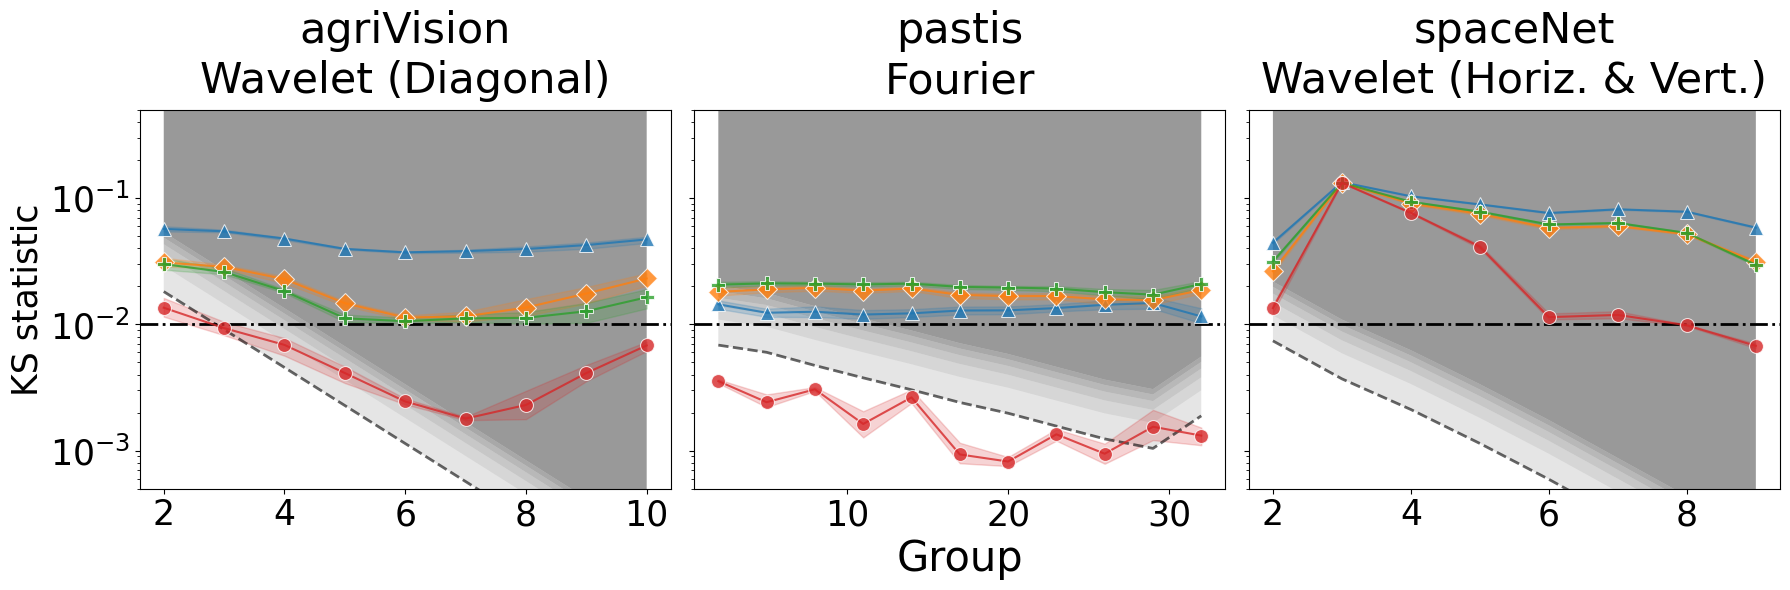

Saved panel figure to c:\Users\yashd\Desktop\hierarchical-bayesian-model-validation\publication\paper\final_plots\results\ksstats_select_remote.jpg


In [44]:
panel_specs = [
    ('agriVision', 'wavelet', 'diagonal', 'agriVision\nWavelet (Diagonal)'),
    ('pastis', 'fourier', None, 'pastis\nFourier'),
    ('spaceNet', 'wavelet', 'horizVert', 'spaceNet\nWavelet (Horiz. & Vert.)')
]

plot_ks_panel(
    main_df,
    panel_specs=panel_specs,
    statistical_cutoffs=statistical_cutoffs,
    alphas=alphas,
    SAVE_FIGS=True,
    plots_path=os.path.join(plots_path, "ksstats_select_remote.jpg")
)


## Natural

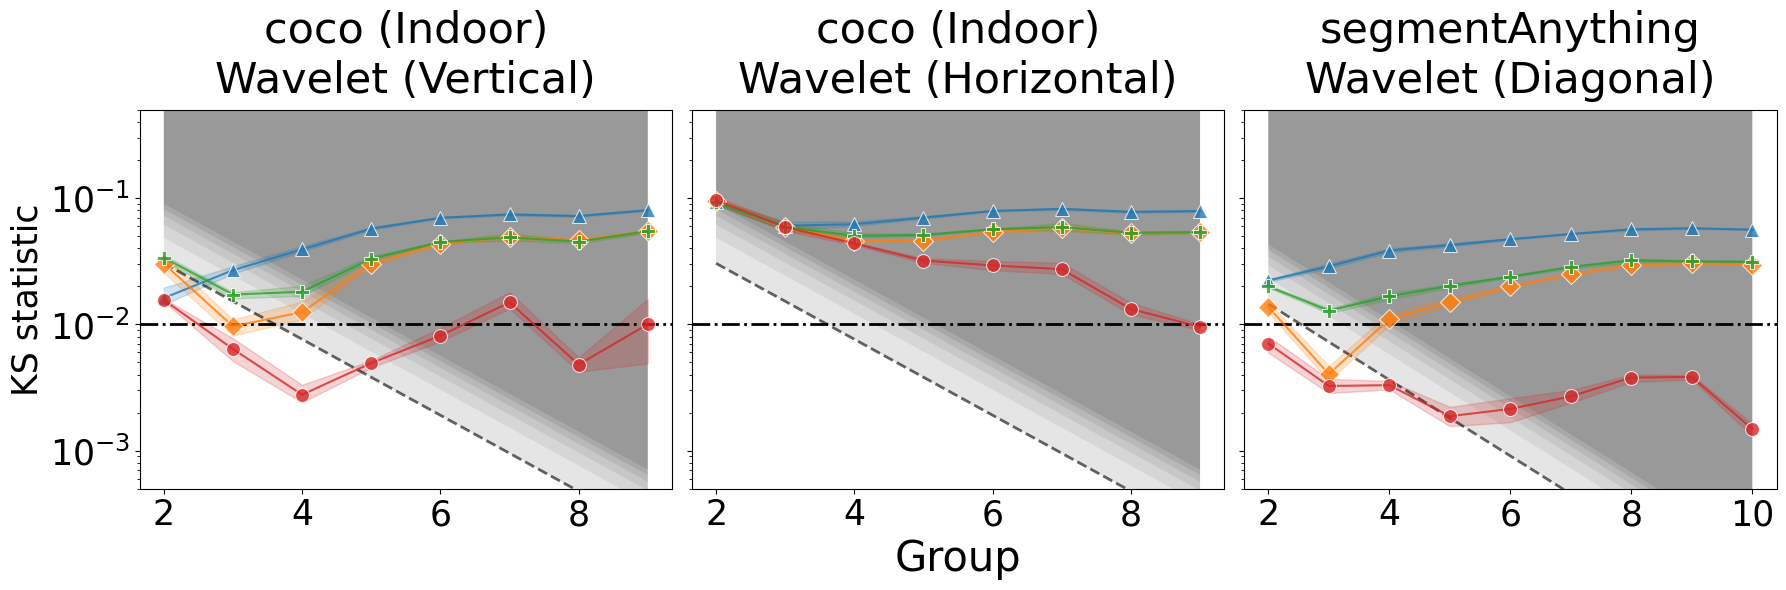

Saved panel figure to c:\Users\yashd\Desktop\hierarchical-bayesian-model-validation\publication\paper\final_plots\results\ksstats_select_natural.jpg


In [45]:
panel_specs = [
    ('coco (indoor)', 'wavelet', 'vertical', 'coco (Indoor)\nWavelet (Vertical)'),
    ('coco (indoor)', 'wavelet', 'horizontal', 'coco (Indoor)\nWavelet (Horizontal)'),
    ('segmentAnything', 'wavelet', 'diagonal', 'segmentAnything\nWavelet (Diagonal)')
]

plot_ks_panel(
    main_df,
    panel_specs=panel_specs,
    statistical_cutoffs=statistical_cutoffs,
    alphas=alphas,
    SAVE_FIGS=True,
    plots_path=os.path.join(plots_path, "ksstats_select_natural.jpg")
)


## Medical Images

Saved figure to c:\Users\yashd\Desktop\hierarchical-bayesian-model-validation\publication\paper\final_plots\results\ksstats_select_medical.jpg


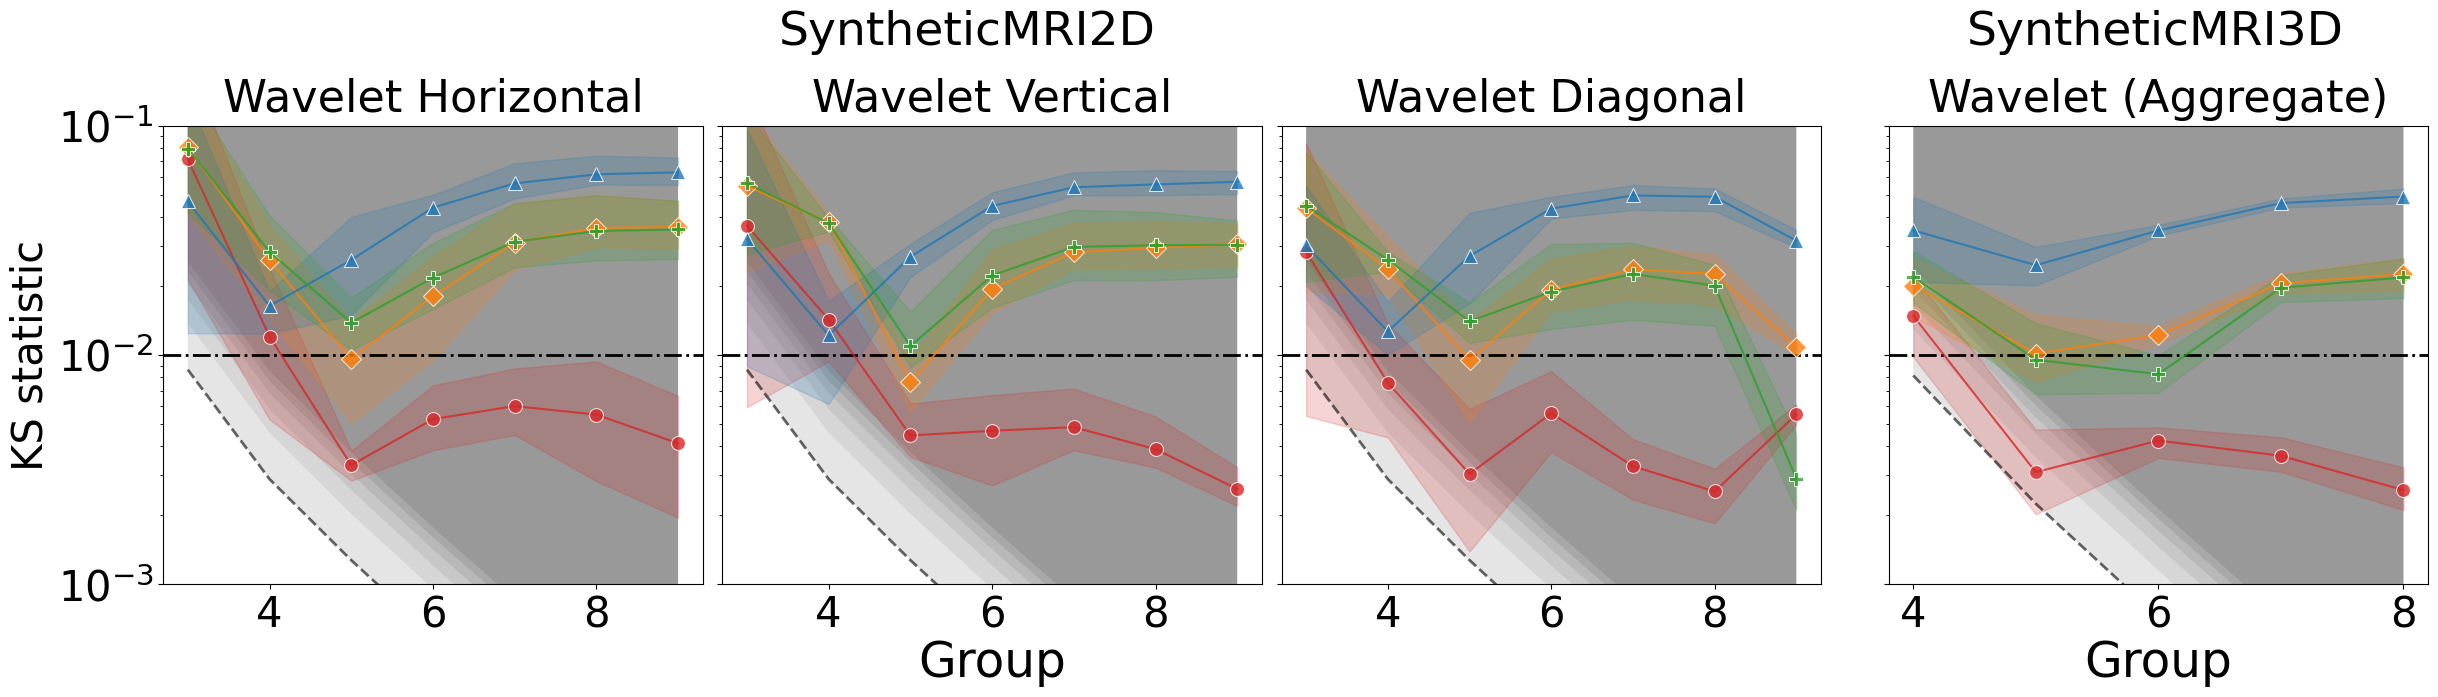

In [46]:
# Consistent prior color/marker scheme
markertypes = ['o', 'D', '^', 'P']
prior_colors = {'o': 'tab:red', 'D': 'tab:orange', '^': 'tab:blue', 'P': 'tab:green'}

# Core setup
log_scale = True
dataset_name = 'syntheticMRI2D'
orientations = ['horizontal', 'vertical', 'diagonal']
num_subsets = len(orientations) + 1  # add one for 3D
fig, axes = plt.subplots(1, num_subsets, figsize=(6 * num_subsets, 6), sharey=True)
marker_size = 10
fontsize = 30

if num_subsets == 1:
    axes = [axes]

# ===========================
# === syntheticMRI2D plots ===
# ===========================
for j, orientation in enumerate(orientations):
    ax = axes[j]
    if log_scale:
        ax.set_yscale('log')

    transform = 'wavelet'
    dataset_filter = main_df['dataset'].str.startswith(dataset_name)
    transform_filter = (
        (main_df['transform'] == transform)
        & (main_df['group'] > 2)
        & (main_df['orientation'] == orientation)
    )
    temp = main_df[dataset_filter & transform_filter].copy()
    temp = temp.sort_values('kstest_stat_cutoff_-1')

    # y-limits
    y_min = temp.filter(regex='kstest_stat_\\w+$').min().min()
    y_max = temp.filter(regex='kstest_stat_\\w+$').max().max()
    y_limits = (10 ** np.floor(np.log10(y_min)), 10 ** np.ceil(np.log10(y_max)))
    ax.set_ylim(y_limits)

    # --- cutoff shading regions ---
    cutoff = temp.groupby('group').agg({
        f'kstest_stat_cutoff_{i}': 'first' for i in statistical_cutoffs
    }).reset_index()

    for k, alpha in enumerate(statistical_cutoffs[:-1]):
        ax.fill_between(
            cutoff['group'],
            cutoff[f'kstest_stat_cutoff_{statistical_cutoffs[k]}'],
            cutoff[f'kstest_stat_cutoff_{statistical_cutoffs[k + 1]}'],
            color='black', alpha=alphas[k], ec=None
        )
    ax.fill_between(
        cutoff['group'],
        cutoff[f'kstest_stat_cutoff_{statistical_cutoffs[-1]}'],
        y_limits[1],
        color='black', alpha=alphas[-1], ec=None
    )

    # Reference lines
    ref_cutoff = f'kstest_stat_cutoff_{statistical_cutoffs[0]}'
    if ref_cutoff in temp.columns:
        ref_line = temp.groupby('group').agg({ref_cutoff: 'first'}).reset_index()
        sns.lineplot(
            x=ref_line['group'], y=ref_line[ref_cutoff],
            linestyle="--", color='black', linewidth=2, alpha=0.6, ax=ax
        )

    ax.axhline(y=practical_pass, linestyle="-.", color='black', linewidth=2)

    # --- KS statistics (consistent colors for priors) ---
    priors = {
        'kstest_stat_best': 'o',
        'kstest_stat_laplace': 'D',
        'kstest_stat_gaussian': '^',
        'kstest_stat_t': 'P'
    }

    for stat_name, marker in priors.items():
        if stat_name in temp.columns:
            sns.lineplot(
                data=temp,
                x='group',
                y=stat_name,
                color=prior_colors[marker],
                marker=marker,
                markersize=marker_size,
                ax=ax,
                alpha=0.8,
                markeredgecolor='white'
            )

    ax.set_xlabel("", fontsize=fontsize)
    ax.set_ylabel("" if j > 0 else "KS statistic", fontsize=fontsize)
    ax.set_title(f"Wavelet {orientation.capitalize()}", fontsize=fontsize + 2, pad=10)
    ax.tick_params(axis='both', which='major', labelsize=fontsize)

# ===========================
# === syntheticMRI3D plot ===
# ===========================
ax3d = axes[-1]
if log_scale:
    ax3d.set_yscale('log')

# Filter for syntheticMRI3D aggregate
dataset_filter = main_df['dataset'].str.startswith("syntheticMRI3D")
transform_filter = (main_df['transform'] == 'wavelet') & (main_df['group'] > 3)
temp3d = main_df[dataset_filter & transform_filter].copy()
temp3d = temp3d.sort_values('kstest_stat_cutoff_-1')

# Match y-limits to 2D plots for consistency
ax3d.set_ylim(y_limits)

# Shading
cutoff3d = temp3d.groupby('group').agg({
    f'kstest_stat_cutoff_{i}': 'first' for i in statistical_cutoffs
}).reset_index()
for k, alpha in enumerate(statistical_cutoffs[:-1]):
    ax3d.fill_between(
        cutoff3d['group'],
        cutoff3d[f'kstest_stat_cutoff_{statistical_cutoffs[k]}'],
        cutoff3d[f'kstest_stat_cutoff_{statistical_cutoffs[k + 1]}'],
        color='black', alpha=alphas[k], ec=None
    )
ax3d.fill_between(
    cutoff3d['group'],
    cutoff3d[f'kstest_stat_cutoff_{statistical_cutoffs[-1]}'],
    y_limits[1],
    color='black', alpha=alphas[-1], ec=None
)

# Reference lines
ref_cutoff = f'kstest_stat_cutoff_{statistical_cutoffs[0]}'
if ref_cutoff in temp3d.columns:
    ref_line = temp3d.groupby('group').agg({ref_cutoff: 'first'}).reset_index()
    sns.lineplot(
        x=ref_line['group'], y=ref_line[ref_cutoff],
        linestyle="--", color='black', linewidth=2, alpha=0.6, ax=ax3d
    )
ax3d.axhline(y=practical_pass, linestyle="-.", color='black', linewidth=2)

# KS statistics with consistent prior colors
for stat_name, marker in priors.items():
    if stat_name in temp3d.columns:
        sns.lineplot(
            data=temp3d,
            x='group',
            y=stat_name,
            color=prior_colors[marker],
            marker=marker,
            markersize=marker_size,
            ax=ax3d,
            alpha=0.8,
            markeredgecolor='white'
        )

ax3d.set_xlabel("", fontsize=fontsize)
ax3d.set_ylabel("", fontsize=fontsize)
ax3d.set_title("Wavelet (Aggregate)", fontsize=fontsize + 2, pad=10)
ax3d.tick_params(axis='both', which='major', labelsize=fontsize)

fig.text(0.405, 1.01, "SyntheticMRI2D", ha='center', fontsize=fontsize + 4)
# Title above rightmost plot
fig.text(0.9, 1.01, "SyntheticMRI3D", ha='center', fontsize=fontsize + 4)

# Apply tight layout first
plt.tight_layout(rect=[0, 0, 1, 0.98])

# === Add extra space only between the 3rd and 4th subplot ===
pos3 = axes[2].get_position()   # position of the 3rd (rightmost 2D) plot
pos4 = axes[3].get_position()   # position of the 4th (3D) plot

# Shift the 4th plot slightly to the right (adjust value as needed)
shift = 0.02  # try between 0.03–0.06 for subtle spacing
axes[3].set_position([
    pos4.x0 + shift, pos4.y0, pos4.width, pos4.height
])

fig.text(
    (axes[1].get_position().x0 + axes[1].get_position().x1) / 2,   # horizontal center of 2nd plot
    0.02,  # vertical position (slightly below tick labels)
    "Group",
    ha='center', va='top',
    fontsize=fontsize + 5
)

# Second label: centered under the 3D plot
fig.text(
    (axes[-1].get_position().x0 + axes[-1].get_position().x1) / 2,
    0.02,
    "Group",
    ha='center', va='top',
    fontsize=fontsize + 5
)

# --- Save figure ---
if SAVE_FIGS:
    save_path = os.path.join(plots_path, "ksstats_select_medical.jpg")
    fig.savefig(save_path, dpi=DPI, bbox_inches='tight')
    print(f"Saved figure to {save_path}")


# Learned Filters

In [47]:
nonskewed_df = pd.read_csv(os.path.join(ROOT_DIR, 'learned-filters', 'nonskewed_filter_idxs_df.csv')).set_index(['dataset', 'num_images', 'num_bootstrap'])
nonskewed_df = nonskewed_df.sort_values('num_images', ascending=False).groupby('dataset').first()
nonskewed_df['num_filters'] = nonskewed_df['nonskewed_filter_idxs'].apply(lambda x : len(eval(x)))
nonskewed_df

,nonskewed_filter_idxs,num_filters
dataset,,
agriVision-full,"[0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",60
coco-indoor,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",62
coco-outdoor,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",64
pastis-full,"[2, 3, 4, 5, 6, 9, 11, 12, 13, 16, 17, 18, 20,...",32
segmentAnything-full,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",61
spaceNet-full,"[0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",56
standardTesting-full,"[0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",54


In [48]:
common_filter_idxs = set.intersection(*[set(eval(i)) for i in nonskewed_df['nonskewed_filter_idxs']])
print(len(common_filter_idxs))

32


In [49]:
filters = pd.read_pickle(os.path.join(ROOT_DIR, 'learned-filters', 'filters.pickle'))
filter_groups = ['dual_color', 'eye', 'inside_out', 'misc', 'multi_edge','single_edge']
renamed_filter_groups = ['3dual_color', '4eye', '5inside_out', '6misc', '2multi_edge','1single_edge']
rename_dict = dict(zip(filter_groups, renamed_filter_groups))
rename_dict

{'dual_color': '3dual_color',
 'eye': '4eye',
 'inside_out': '5inside_out',
 'misc': '6misc',
 'multi_edge': '2multi_edge',
 'single_edge': '1single_edge'}

In [50]:
transform='learned'
marker_size = 100
fontsize=25

fixed_palette = {'single_edge': 'red',
                'multi_edge': 'blue',
                'eye': 'xkcd:dark yellow',
                'dual_color': 'darkgreen',
                'inside_out': 'purple',
                'misc': 'orange'}

priors = ['kstest_stat_gaussian', 'kstest_stat_laplace', 'kstest_stat_t', 'kstest_stat_best']
prior_markers = {'kstest_stat_gaussian': '^', 'kstest_stat_laplace': 'D', 
                'kstest_stat_t': 'P', 'kstest_stat_best': 'o'}

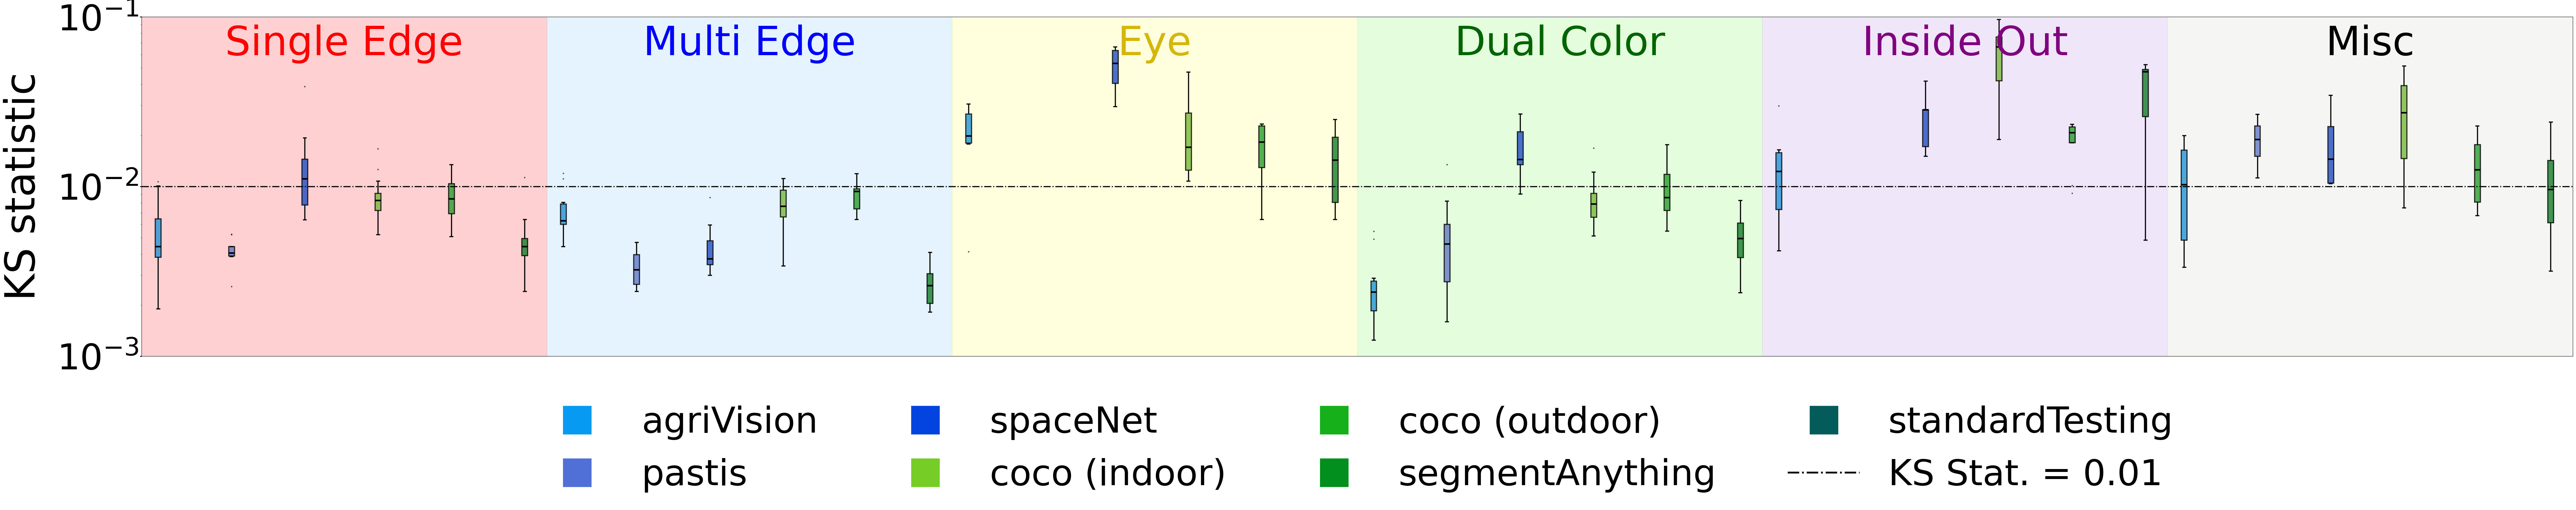

In [51]:
# === Core styling parameters ===
fontsize = 80          # base font size
box_width = 0.6
transform = 'learned'
practical_pass = 0.01  # KS threshold

# === Filter-group (orientation) colors ===
fixed_palette = {
    'single_edge': 'red',
    'multi_edge': 'blue',
    'eye': 'xkcd:dark yellow',
    'dual_color': 'darkgreen',
    'inside_out': 'purple',
    'misc': 'black'
}

# === Dataset colors (include standardTesting) ===
dataset_palette = {
    'agriVision': 'xkcd:azure',
    'pastis': 'xkcd:cornflower blue',
    'spaceNet': 'xkcd:blue',
    'coco (indoor)': 'xkcd:apple green',
    'coco (outdoor)': 'xkcd:green',
    'segmentAnything': 'xkcd:emerald green',
    'standardTesting': 'xkcd:dark turquoise'
}

# === Light backgrounds for each filter group ===
bg_colors = {
    'single_edge': 'xkcd:light red',
    'multi_edge': 'xkcd:light blue',
    'eye': 'xkcd:light yellow',
    'dual_color': 'xkcd:light green',
    'inside_out': 'xkcd:lavender',
    'misc': 'xkcd:light grey'
}

# === Prepare data ===
temp = main_df[main_df['transform'] == transform].copy()
temp = temp.rename(columns={'kstest_stat_best': 'GenGamma Hyperprior'})

orientation_order = list(fixed_palette.keys())
dataset_order = list(dataset_palette.keys())

temp['orientation'] = pd.Categorical(temp['orientation'], categories=orientation_order, ordered=True)
temp['dataset'] = pd.Categorical(temp['dataset'], categories=dataset_order, ordered=True)
temp = temp.sort_values(['orientation', 'dataset']).reset_index(drop=True)

temp['xcat'] = temp['orientation'].astype(str) + " | " + temp['dataset'].astype(str)
x_order = [f"{o} | {d}" for o in orientation_order for d in dataset_order if d in temp['dataset'].unique()]

# === Create figure ===
fig, ax = plt.subplots(figsize=(80, 16), facecolor='white')
ax.set_facecolor('white')

# Background shading per orientation group
for o in orientation_order:
    group_cats = [x for x in x_order if x.startswith(o + " | ")]
    if not group_cats:
        continue
    start_idx = x_order.index(group_cats[0])
    end_idx = x_order.index(group_cats[-1])
    ax.axvspan(start_idx - 0.5, end_idx + 0.5, color=bg_colors[o], alpha=0.25, zorder=0)

# Boxplots colored by dataset
sns.boxplot(
    data=temp,
    x='xcat',
    y='GenGamma Hyperprior',
    order=x_order,
    hue='dataset',
    palette=dataset_palette,
    fliersize=2,
    linewidth=2.5,  # thicker overall box edges
    width=box_width,
    ax=ax,
    boxprops=dict(alpha=0.8, edgecolor='black', linewidth=2.5),
    medianprops=dict(color='black', linewidth=3.5),
    whiskerprops=dict(color='black', linewidth=2.5),
    capprops=dict(color='black', linewidth=2.5)
)

# Practical Pass line
ax.axhline(y=practical_pass, linestyle="-.", color='black', linewidth=2.5, zorder=3)

# === Axes formatting ===
ax.set_yscale('log')
ax.set_ylim((1e-3, 1e-1))
ax.set_xlim((-0.5, len(x_order) - 0.5))
ax.set_ylabel("KS statistic", fontsize=fontsize + 12, color='black', labelpad=30)
ax.set_xlabel("")
ax.set_xticklabels([])

ax.tick_params(axis='y', which='major', labelsize=fontsize, width=2, colors='black')
ax.tick_params(axis='x', bottom=False, top=False)
ax.legend().set_visible(False)

# === Orientation headers (slightly lower) ===
ymax = ax.get_ylim()[1]
for o in orientation_order:
    group_cats = [x for x in x_order if x.startswith(o + " | ")]
    if not group_cats:
        continue
    start_idx = x_order.index(group_cats[0])
    end_idx = x_order.index(group_cats[-1])
    mid_idx = (start_idx + end_idx) / 2
    ax.text(
        mid_idx,
        ymax * 0.90,  # lowered from 0.95 → gives more breathing room
        o.replace('_', ' ').title(),
        fontsize=fontsize + 10,
        color=fixed_palette[o],
        ha='center',
        va='top'
    )

legend_elements = [
    Line2D([0], [0], marker='s', color='w', label=k,
           markerfacecolor=v, markersize=26)
    for k, v in dataset_palette.items()
]
legend_elements.append(
    Line2D([0], [0], color='black', linestyle='-.', linewidth=4, label='KS Stat. = 0.01')
)

ax.legend(
    handles=legend_elements,
    loc='upper center',
    fontsize=fontsize,
    markerscale=2.5,
    ncol=len(legend_elements)//2,
    bbox_to_anchor=(0.5, -0.05),
    frameon=False
)

plt.tight_layout()
plt.show()

if SAVE_FIGS:
    save_path = os.path.join(plots_path, "ksstats_select_learned.jpg")
    fig.savefig(save_path, dpi=DPI, bbox_inches='tight')


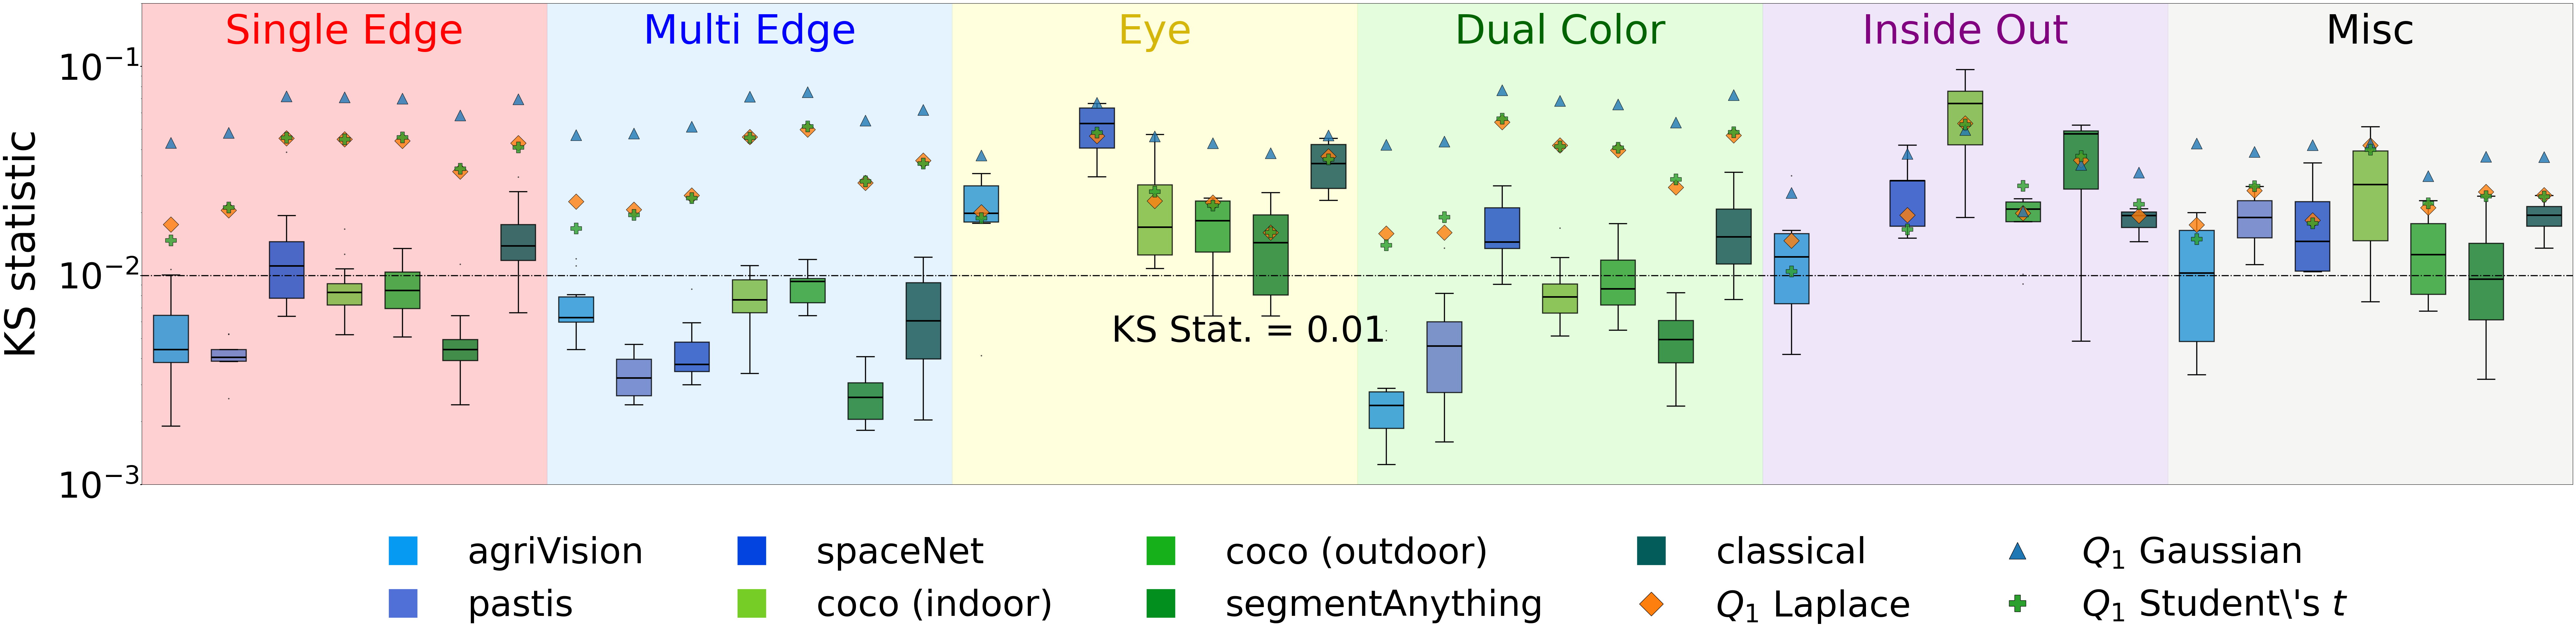

In [52]:
# === Core styling parameters ===
fontsize = 80          # base font size
box_width = 0.6
transform = 'learned'
practical_pass = 0.01  # KS threshold
quantile_value = 0.25  # Quantile for other priors (0.25 for 25th percentile, 0.5 for median, etc.)

# === Define priors and their markers/colors ===
other_priors = ['kstest_stat_laplace', 'kstest_stat_gaussian', 'kstest_stat_t']
markertypes = ['D', '^', 'P']
prior_colors = {'D': 'tab:orange', '^': 'tab:blue', 'P': 'tab:green'}
prior_markers = dict(zip(other_priors, markertypes))

# === Filter-group (orientation) colors ===
fixed_palette = {
    'single_edge': 'red',
    'multi_edge': 'blue',
    'eye': 'xkcd:dark yellow',
    'dual_color': 'darkgreen',
    'inside_out': 'purple',
    'misc': 'black'
}

# === Dataset colors (include standardTesting) ===
dataset_palette = {
    'agriVision': 'xkcd:azure',
    'pastis': 'xkcd:cornflower blue',
    'spaceNet': 'xkcd:blue',
    'coco (indoor)': 'xkcd:apple green',
    'coco (outdoor)': 'xkcd:green',
    'segmentAnything': 'xkcd:emerald green',
    'classical': 'xkcd:dark turquoise'
}

# === Light backgrounds for each filter group ===
bg_colors = {
    'single_edge': 'xkcd:light red',
    'multi_edge': 'xkcd:light blue',
    'eye': 'xkcd:light yellow',
    'dual_color': 'xkcd:light green',
    'inside_out': 'xkcd:lavender',
    'misc': 'xkcd:light grey'
}

# === Prepare data ===
temp = main_df[main_df['transform'] == transform].copy()
temp = temp.rename(columns={'kstest_stat_best': 'GenGamma Hyperprior'})

orientation_order = list(fixed_palette.keys())
dataset_order = list(dataset_palette.keys())

temp['orientation'] = pd.Categorical(temp['orientation'], categories=orientation_order, ordered=True)
temp['dataset'] = pd.Categorical(temp['dataset'], categories=dataset_order, ordered=True)
temp = temp.sort_values(['orientation', 'dataset']).reset_index(drop=True)

temp['xcat'] = temp['orientation'].astype(str) + " | " + temp['dataset'].astype(str)
x_order = [f"{o} | {d}" for o in orientation_order for d in dataset_order if d in temp['dataset'].unique()]

# === Calculate quantile values per xcat for each prior ===
quantile_values_by_xcat = {}
for prior in other_priors:
    quantile_values_by_xcat[prior] = temp.groupby('xcat')[prior].quantile(quantile_value).to_dict()

# === Create figure ===
fig, ax = plt.subplots(figsize=(80, 20), facecolor='white')
ax.set_facecolor('white')

# Background shading per orientation group
for o in orientation_order:
    group_cats = [x for x in x_order if x.startswith(o + " | ")]
    if not group_cats:
        continue
    start_idx = x_order.index(group_cats[0])
    end_idx = x_order.index(group_cats[-1])
    ax.axvspan(start_idx - 0.5, end_idx + 0.5, color=bg_colors[o], alpha=0.25, zorder=0)

# Boxplots colored by dataset
sns.boxplot(
    data=temp,
    x='xcat',
    y='GenGamma Hyperprior',
    order=x_order,
    hue='dataset',
    palette=dataset_palette,
    fliersize=2,
    linewidth=2.5,  # thicker overall box edges
    width=box_width,
    ax=ax,
    boxprops=dict(alpha=0.8, edgecolor='black', linewidth=2.5),
    medianprops=dict(color='black', linewidth=3.5),
    whiskerprops=dict(color='black', linewidth=2.5),
    capprops=dict(color='black', linewidth=2.5)
)

# === Add quantile points for each prior above each boxplot ===
marker_size = 600
for xcat_idx, xcat in enumerate(x_order):
    for prior in other_priors:
        quantile_val = quantile_values_by_xcat[prior].get(xcat)
        if quantile_val is not None:
            marker = prior_markers[prior]
            ax.scatter(
                xcat_idx,
                quantile_val,
                marker=marker,
                s=marker_size,
                color=prior_colors[marker],
                alpha=0.8,
                zorder=5,
                edgecolors='black',
                linewidths=1
            )

# Practical Pass line
ax.axhline(y=practical_pass, linestyle="-.", color='black', linewidth=2.5, zorder=3)

# === Axes formatting ===
ax.set_yscale('log')
ax.set_ylim((1e-3, 2*1e-1))
ax.set_xlim((-0.5, len(x_order) - 0.5))
ax.set_ylabel("KS statistic", fontsize=fontsize + 12, color='black', labelpad=30)
ax.set_xlabel("")
ax.set_xticklabels([])

ax.tick_params(axis='y', which='major', labelsize=fontsize, width=2, colors='black')
ax.tick_params(axis='x', bottom=False, top=False)
ax.legend().set_visible(False)

# === Orientation headers (slightly lower) ===
ymax = ax.get_ylim()[1]
for o in orientation_order:
    group_cats = [x for x in x_order if x.startswith(o + " | ")]
    if not group_cats:
        continue
    start_idx = x_order.index(group_cats[0])
    end_idx = x_order.index(group_cats[-1])
    mid_idx = (start_idx + end_idx) / 2
    ax.text(
        mid_idx,
        ymax * 0.90,  # lowered from 0.95 → gives more breathing room
        o.replace('_', ' ').title(),
        fontsize=fontsize + 10,
        color=fixed_palette[o],
        ha='center',
        va='top'
    )

# === Legend ===
legend_elements = [
    Line2D([0], [0], marker='s', color='w', label=k,
           markerfacecolor=v, markersize=26)
    for k, v in dataset_palette.items()
]

# Add annotation below the line
ax.text(
    len(x_order)//2,  # Position at the right end
    practical_pass * 0.65,  # Position below the line (adjust multiplier as needed)
    'KS Stat. = 0.01',
    fontsize=fontsize,
    color='black',
    ha='right',
    va='top'
)

# Add prior marker legends
prior_labels = {
    'kstest_stat_best': 'Best Prior',
    'kstest_stat_laplace': 'Laplace',
    'kstest_stat_gaussian': 'Gaussian',
    'kstest_stat_t': r'Student\'s $t$'
}
quantile_label = r"$Q_1$" if quantile_value != 0.5 else "Median" # f"{int(quantile_value * 100)}th percentile" if quantile_value != 0.5 else "Median"
for prior in other_priors:
    marker = prior_markers[prior]
    legend_elements.append(
        Line2D([0], [0], marker=marker, color='w',
               markerfacecolor=prior_colors[marker], markersize=15,
               markeredgecolor='black', markeredgewidth=1,
               label=f"{quantile_label} {prior_labels[prior]}", linestyle='None')
    )

ax.legend(
    handles=legend_elements,
    loc='upper center',
    fontsize=fontsize,
    markerscale=2.5,
    ncol=len(legend_elements)//2,
    bbox_to_anchor=(0.5, -0.04),
    frameon=False
)

plt.tight_layout()
plt.show()

if SAVE_FIGS:
    save_path = os.path.join(plots_path, "ksstats_select_learned_with_other_priors.jpg")
    fig.savefig(save_path, dpi=DPI, bbox_inches='tight')